In [1]:
import itertools

import six

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV

# meta-estimator
from sklearn.pipeline import make_pipeline

# metric
from sklearn.metrics import (r2_score, median_absolute_error,
                             confusion_matrix)

### IO: Reading and preprocess the data

We can define a function which will read the data and process them.

In [2]:
def read_spectra(path_csv):
    """Read and parse data in pandas DataFrames.
    
    Parameters
    ----------
    path_csv : str
        Path to the CSV file to read.
        
    Returns
    -------
    spectra : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all Raman spectra.
        
    concentration : pandas Series, shape (n_spectra,)
        Series containing the concentration of the molecule.
        
    molecule : pandas Series, shape (n_spectra,)
        Series containing the type of chemotherapeutic agent.
        
    """
    if not isinstance(path_csv, six.string_types):
        raise TypeError("'path_csv' needs to be string. Got {}"
                        " instead.".format(type(path_csv)))
        if not path_csv.endswith('.csv'):
            raise ValueError('Wrong file format. Expecting csv file')
    
    data = pd.read_csv(path_csv)
    concentration = data['concentration']
    molecule = data['molecule']
    spectra_string = data['spectra']
    spectra = []
    for spec in spectra_string:
        # remove the first and last bracket and convert to a numpy array
        spectra.append(np.fromstring(spec[1:-1], sep=','))
    spectra = pd.DataFrame(spectra)
    
    return spectra, concentration, molecule

In [3]:
# read the frequency and get a pandas serie
frequency = pd.read_csv('data/freq.csv')['freqs']

# read all data for training
filenames = ['data/spectra_{}.csv'.format(i)
             for i in range(4)]

spectra, concentration, molecule = [], [], []
for filename in filenames:
    spectra_file, concentration_file, molecule_file = read_spectra(filename)
    spectra.append(spectra_file)
    concentration.append(concentration_file)
    molecule.append(molecule_file)

# Concatenate in single DataFrame and Serie
spectra = pd.concat(spectra)
concentration = pd.concat(concentration)
molecule = pd.concat(molecule)

### Plot helper functions

We can create two functions: (i) to plot all spectra and (ii) plot the mean spectra with the std intervals.
We will make a "private" function which will be used by both plot types.

In [4]:
def _apply_axis_layout(ax, title):
    """Apply despine style and add labels to axis."""
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Concentration')
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

def plot_spectra(frequency, spectra, title):
    """Plot a bunch of Raman spectra.
    
    Parameters
    ----------
    frequency : pandas Series, shape (n_freq_points,)
        Frequencies for which the Raman spectra were acquired.
        
    spectra : pandas DataFrame, shape (n_spectra, n_freq_points)
        DataFrame containing all Raman spectra.
        
    title : str
        Title added to the plot.
    
    Returns
    -------
    None
    
    """
    fig, ax = plt.subplots()
    ax.plot(frequency, spectra.T)
    _apply_axis_layout(ax, title)
    
def plot_spectra_by_type(frequency, spectra, classes, title):
    """Plot mean spectrum with its variance for a given class.
    
    Parameters
    ----------
    frequency : pandas Series, shape (n_freq_points,)
        Frequencies for which the Raman spectra were acquired.
        
    spectra : pandas DataFrame, shape (n_spectra, n_freq_points)
        DataFrame containing all Raman spectra.
        
    classes : array-like, shape (n_classes,)
        Array contining the different spectra class which will be plotted.
        
    title : str
        Title added to the plot.
        
    Returns
    -------
    None
    
    """
    fig, ax = plt.subplots()
    for label in np.unique(classes):
        label_index = np.flatnonzero(classes == label)
        spectra_mean = np.mean(spectra.iloc[label_index], axis=0)
        spectra_std = np.std(spectra.iloc[label_index], axis=0)
        ax.plot(frequency, spectra_mean, label=label)
        ax.fill_between(frequency,
                        spectra_mean + spectra_std,
                        spectra_mean - spectra_std,
                        alpha=0.2)
    _apply_axis_layout(ax, title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

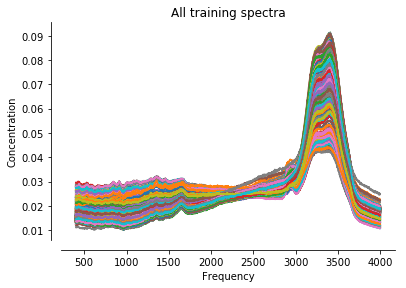

In [5]:
plot_spectra(frequency, spectra, 'All training spectra')

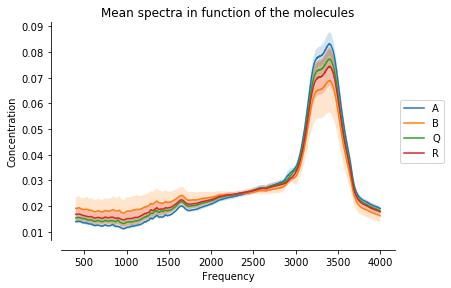

In [6]:
plot_spectra_by_type(frequency, spectra, molecule,
                     'Mean spectra in function of the molecules')

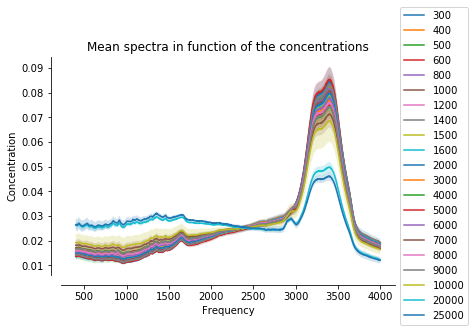

In [7]:
plot_spectra_by_type(frequency, spectra, concentration,
                     'Mean spectra in function of the concentrations')

### Reusability for new data:

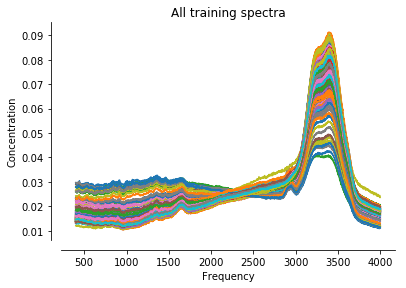

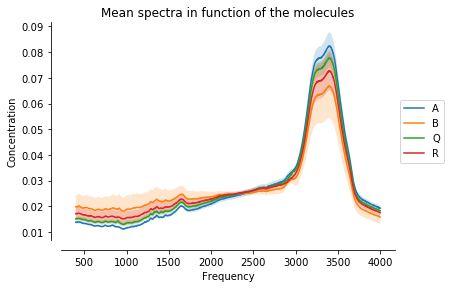

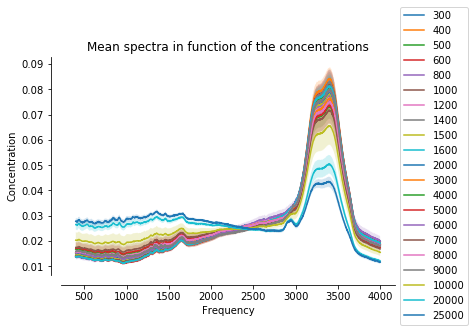

In [8]:
spectra_test, concentration_test, molecule_test = read_spectra('data/spectra_4.csv')

plot_spectra(frequency, spectra_test,
             'All training spectra')
plot_spectra_by_type(frequency, spectra_test, molecule_test,
                     'Mean spectra in function of the molecules')
plot_spectra_by_type(frequency, spectra_test, concentration_test,
                     'Mean spectra in function of the concentrations')

## Training and testing a machine learning model for classification

In [9]:
def plot_cm(cm, classes, title):
    """Plot a confusion matrix.
    
    Parameters
    ----------
    cm : ndarray, shape (n_classes, n_classes)
        Confusion matrix.
        
    classes : array-like, shape (n_classes,)
        Array contining the different spectra classes used in the
        classification problem.
        
    title : str
        Title added to the plot.
        
    Returns
    -------
    None
    
    """
    fig, ax = plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap='bwr')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy score: 0.83
Accuracy score: 0.93


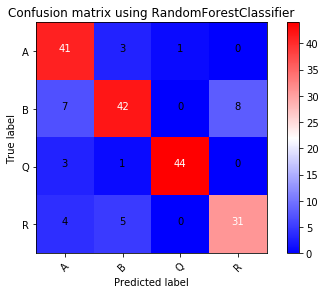

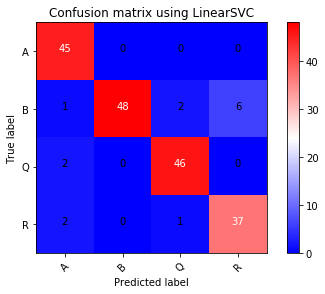

In [10]:
for clf in [RandomForestClassifier(random_state=0),
            LinearSVC(random_state=0)]:
    
    pipeline = make_pipeline(StandardScaler(),
                             PCA(n_components=100, random_state=0),
                             clf)
    y_pred = pipeline.fit(spectra, molecule).predict(spectra_test)
    plot_cm(confusion_matrix(molecule_test, y_pred),
            pipeline.classes_,
            'Confusion matrix using {}'.format(clf.__class__.__name__))
    print('Accuracy score: {0:.2f}'.format(pipeline.score(spectra_test,
                                                          molecule_test)))

## Training and testing a machine learning model for regression

In [11]:
def plot_regression(y_true, y_pred, title):
    """Plot actual vs. predicted scatter plot.
    
    Parameters
    ----------
    y_true : array-like, shape (n_samples,)
        Ground truth (correct) target values.

    y_pred : array-like, shape (n_samples,)
        Estimated targets as returned by a regressor.

    title : str
        Title added to the plot.
    
    Returns
    -------
    None
    
    """    
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([0, 25000], [0, 25000], '--k')
    ax.set_ylabel('Target predicted')
    ax.set_xlabel('True Target')
    ax.set_title(title)
    ax.text(1000, 20000, r'$R^2$=%.2f, MAE=%.2f' % (
       r2_score(y_true, y_pred), median_absolute_error(y_true, y_pred)))
    ax.set_xlim([0, 25000])
    ax.set_ylim([0, 25000])

In [12]:
def regression_experiment(X_train, X_test, y_train, y_test):
    """Perform regression experiment.
    
    Build a pipeline using PCA and either a Ridge
    or a RandomForestRegressor model.
    
    Parameters
    ----------
    X_train : pandas DataFrame, shape (n_spectra, n_freq_points)
        DataFrame containing training Raman spectra.
        
    X_test : pandas DataFrame, shape (n_spectra, n_freq_points)
        DataFrame containing testing Raman spectra.
        
    y_training : pandas Serie, shape (n_spectra,)
        Serie containing the training concentrations acting as targets.
        
    y_testing : pandas Serie, shape (n_spectra,)
        Serie containing the testing concentrations acting as targets.
        
    Returns
    -------
    None
    
    """
    for reg in [RidgeCV(), RandomForestRegressor(random_state=0)]:
        pipeline = make_pipeline(PCA(n_components=100), reg)
        y_pred = pipeline.fit(X_train, y_train).predict(X_test)
        plot_regression(y_test, y_pred,
                        'Regression using {}'.format(reg.__class__.__name__))

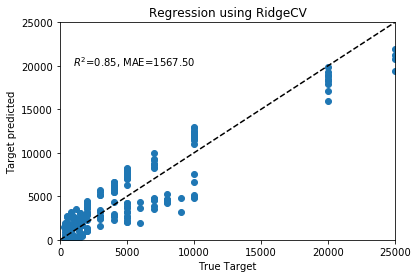

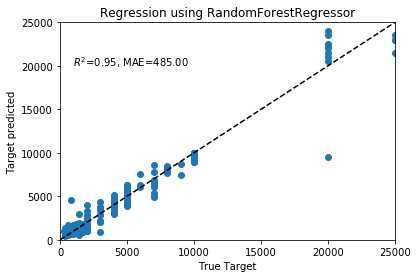

In [13]:
regression_experiment(spectra, spectra_test,
                      concentration, concentration_test)

In [14]:
def fit_params(data):
    """Compute statistics for robustly scale data.
    
    Compute the median and the variance, i.e. the difference
    between the 75th and 25th percentiles.
    These statistics are used later to scale data.
    
    Parameters
    ----------
    data : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all Raman spectra.
        
    Returns
    -------
    median : ndarray, shape (n_freq_point,)
        Median for each wavelength.
        
    variance : ndarray, shape (n_freq_point,)
        Variance (difference between the 75th and 25th
        percentiles) for each wavelength.
    
    """
    median = np.median(data, axis=0)
    percentile_25 = np.percentile(data, 25, axis=0)
    percentile_75 = np.percentile(data, 75, axis=0)
    return median, (percentile_75 - percentile_25)

def transform(data, median, var_25_75):
    """Scale data using robust estimators.
    
    Scale the data by subtracting the median and dividing by the
    variance, i.e. the difference between the 75th and 25th percentiles.
    
    Parameters
    ----------
    data : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all Raman spectra.
        
    median : ndarray, shape (n_freq_point,)
        Median for each wavelength.
        
    var_25_75 : ndarray, shape (n_freq_point,)
        Variance (difference between the 75th and 25th
        percentiles) for each wavelength.
    
    Returns
    -------
    data_scaled : pandas DataFrame, shape (n_spectra, n_freq_point)
        DataFrame containing all scaled Raman spectra.
    
    """
    return (data - median) / var_25_75

In [15]:
# compute the statistics on the training data
med, var = fit_params(spectra)
# transform the training and testing data
spectra_scaled = transform(spectra, med, var)
spectra_test_scaled = transform(spectra_test, med, var)

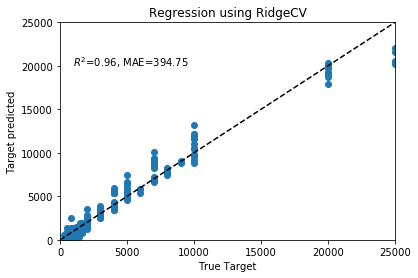

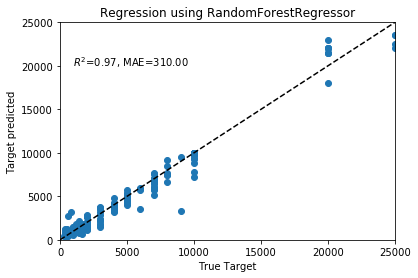

In [16]:
regression_experiment(spectra_scaled, spectra_test_scaled,
                      concentration, concentration_test)